# Importing Libraries

In [4]:
import numpy as np, pandas as pd
import json
import ast 
from textblob import TextBlob
import nltk
import torch
import pickle
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')
import spacy
from nltk import Tree
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from models import InferSent
from sklearn.preprocessing import StandardScaler, MinMaxScaler,QuantileTransformer

# Convert JSON to Pandas Dataframe

In [5]:
train = pd.read_json("/kaggle/working/squad11/train-v1.1.json") #Read the train data JSON File
valid = pd.read_json("/kaggle/working/squad11/dev-v1.1.json") #Read the valid data JSON File

In [6]:
train.shape, valid.shape

((442, 2), (48, 2))

In [7]:
contexts = []       
questions = []
answers_text = []
answers_start = []
for i in range(train.shape[0]):
    topic = train.iloc[i,0]['paragraphs'] # To select each paragraph from data and gather corresponding info of it.
    for sub_para in topic:
        for q_a in sub_para['qas']:
            questions.append(q_a['question']) # To get Question of each paragraph 
            answers_start.append(q_a['answers'][0]['answer_start']) # To get the start index of answer
            answers_text.append(q_a['answers'][0]['text']) # To get the Answer for the question
            contexts.append(sub_para['context']) # To get the context of the paragraph
df = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "text": answers_text})

In [8]:
# Taking only 25% of total dataset
df = df[:20000]

In [9]:
df.shape

(20000, 4)

In [10]:
df.to_csv("train.csv", index = None) # Change JSON file to CSV file

## Create dictionary of sentence embeddings for faster computation

In [11]:
paras = list(df["context"].drop_duplicates().reset_index(drop= True)) # Create List of all Contexts and drop duplicates

In [12]:
len(paras)

4463

In [13]:
blob = TextBlob(" ".join(paras)) 
sentences = [item.raw for item in blob.sentences]

In [14]:
len(sentences)

17713

In [15]:

V = 2
MODEL_PATH = '/kaggle/working/squad11/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V} # Model Parameters For Infersent Model
infersent = InferSent(params_model) # Infersent Pre Trained encoder by Facebook
infersent.load_state_dict(torch.load(MODEL_PATH)) # Load Dictionary

<All keys matched successfully>

In [16]:
W2V_PATH = '/kaggle/working/squad11/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH) # Set the Word To Vector Path for embeddings

In [17]:
infersent

InferSent(
  (enc_lstm): LSTM(300, 2048, bidirectional=True)
)

In [18]:
infersent.build_vocab(sentences, tokenize=True) # Using Function of InferSent Class to build vocabulary

Found 34889(/38881) words with w2v vectors
Vocab size : 34889


## Generating word embeddings

In [19]:
dict_embeddings = {}
for i in range(len(sentences)):
    dict_embeddings[sentences[i]] = infersent.encode([sentences[i]], tokenize=True) # Encode the sentences in dict_embeddings

In [20]:
questions = list(df["question"]) #Use the question column from df and create a list

In [21]:
len(questions)

20000

In [22]:
for i in range(len(questions)):
    dict_embeddings[questions[i]] = infersent.encode([questions[i]], tokenize=True) # Generate encoding for questions

# Create dictionary with each Sentence and corresponding word embeddings array 

In [23]:
d1 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 0} 
d2 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 1}

In [24]:
train = pd.read_csv("train.csv") # Load the train data CSV file

In [25]:
train.shape

(20000, 4)

In [26]:
# Open the file and dump the word embeddings in d1 in file
with open('dict_1.pickle', 'wb') as handle:
    pickle.dump(d1, handle)

In [27]:
# Open the file and dump the word embeddings in d2 in file
with open('dict_2.pickle', 'wb') as handle:
    pickle.dump(d2, handle)

### Loading Embedding dictionary

In [28]:
# Open the pickle file 1 with word embeddings and load to d1
with open("dict_1.pickle", "rb") as f:
    d1 = pickle.load(f)

In [29]:
# Open the pickle file 2 with word embeddings and load to d2
with open("dict_2.pickle", "rb") as f:
    d2 = pickle.load(f)

In [30]:
# Concatenate the two dictionaries with word embeddings in one dict_emb
dict_emb = dict(d1)
dict_emb.update(d2)

In [31]:
len(dict_emb)

37613

## Data Pre-Processing

In [32]:
# This function sets the value of column Target which is the sentence number in the paragraph which contains the answer.
def get_target(x):
    idx = -1
    for i in range(len(x["sentences"])):
        if x["text"] in x["sentences"][i]: idx = i
    return idx

In [33]:
train.head(3)

,context,question,answer_start,text
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building


In [34]:
train.shape

(20000, 4)

In [35]:
# Use of dropna function to drop null values using inplace=True to make the changes in CSV file automatic 
train.dropna(inplace=True)

## Processing Data

In [36]:
# This function to add the extra columns to the training data: sentences, target, sent_emb, quest_emb
def process_data(train):
    
    print("step 1")
    train['sentences'] = train['context'].apply(lambda x: [item.raw for item in TextBlob(x).sentences])
    
    print("step 2")
    train["target"] = train.apply(get_target, axis = 1)
    
    print("step 3")
    train['sent_emb'] = train['sentences'].apply(lambda x: [dict_emb[item][0] if item in
                                                           dict_emb else np.zeros(4096) for item in x])
    print("step 4")
    train['quest_emb'] = train['question'].apply(lambda x: dict_emb[x] if x in dict_emb else np.zeros(4096) )
        
    return train   

In [37]:
# Run this to process data to add columns 
train = process_data(train)

step 1
step 2
step 3
step 4


In [38]:
train.shape

(20000, 8)

In [39]:
train.head(3)

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"[Architecturally, the school has a Catholic ch...",5,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, 0.024210272, 0.069616325, -0.0..."
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"[Architecturally, the school has a Catholic ch...",2,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.033483382, 0.040545918, -0...."
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"[Architecturally, the school has a Catholic ch...",3,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.043944724, 0.14385942, -0.0..."


## Predicted Cosine & Euclidean Index

In [40]:
#Find the Cosine similarity Between Question and Answer 
def cosine_sim(x):
    li = []
    for item in x["sent_emb"]:
        li.append(spatial.distance.cosine(item,x["quest_emb"][0]))
    return li   

In [41]:
#This function is to find the argmin between all the distances of a single sentence array to find the predicted target ...
#sentence number
def pred_idx(distances):
    return np.argmin(distances)

In [42]:
# The euclidean distance and cosine similarity are calculated and predictions are made using above function and stored 
def predictions(train):
    
    train["cosine_sim"] = train.apply(cosine_sim, axis = 1)
    train["diff"] = (train["quest_emb"] - train["sent_emb"])**2
    train["euclidean_dis"] = train["diff"].apply(lambda x: list(np.sum(x, axis = 1)))
    del train["diff"]
    
    print("cosine start")
    
    train["pred_idx_cos"] = train["cosine_sim"].apply(lambda x: pred_idx(x))
    train["pred_idx_euc"] = train["euclidean_dis"].apply(lambda x: pred_idx(x))
    
    return train

In [43]:
#Call to make the predictions
predicted = predictions(train)

cosine start


In [44]:
predicted.shape

(20000, 12)

In [45]:
predicted.head(3)

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"[Architecturally, the school has a Catholic ch...",5,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, 0.024210272, 0.069616325, -0.0...","[0.6835565567016602, 0.5527453124523163, 0.574...","[7.301305, 6.4764132, 7.214262, 6.9176197, 6.5...",5,5
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"[Architecturally, the school has a Catholic ch...",2,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.033483382, 0.040545918, -0....","[0.6624992787837982, 0.5191770792007446, 0.592...","[5.717004, 5.076439, 6.3408985, 3.5867877, 4.8...",3,3
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"[Architecturally, the school has a Catholic ch...",3,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.043944724, 0.14385942, -0.0...","[0.5955168306827545, 0.4985509514808655, 0.539...","[5.209466, 4.929249, 5.8485556, 2.803293, 3.64...",3,3


In [46]:
predicted["cosine_sim"][0]

[0.6835565567016602,
 0.5527453124523163,
 0.5747938454151154,
 0.624308854341507,
 0.619026243686676,
 0.25835102796554565,
 0.5743658542633057]

In [47]:
predicted["euclidean_dis"][0]

[7.301305, 6.4764132, 7.214262, 6.9176197, 6.519748, 3.6410067, 6.9080434]

## Accuracy

In [48]:
# Calculate the accuracy between predicted and target values
def accuracy(target, predicted):
    acc = (target==predicted).sum()/len(target)
    return acc

### Accuracy for  euclidean Distance

In [49]:
print(accuracy(predicted["target"], predicted["pred_idx_euc"]))

0.5296


### Accuracy for Cosine Similarity

In [50]:
print(accuracy(predicted["target"], predicted["pred_idx_cos"]))

0.62515


In [51]:
#Write back the final data with predicted values to a CSV file
predicted.to_csv("train_detect_sent.csv", index=None)

In [127]:
#Read the new CSV file
predicted = pd.read_csv("train_detect_sent.csv").reset_index(drop=True)

In [128]:
#Use spaCy Open source Library to load the data needed for to process for English Language
en_nlp=spacy.load('en_core_web_md')
doc = en_nlp(predicted.iloc[0,1])

In [131]:
predicted

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"['Architecturally, the school has a Catholic c...",5,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 0.02421027 0.06961633 ... 0.0...,"[0.6835565567016602, 0.5527453124523163, 0.574...","[7.301305, 6.4764132, 7.214262, 6.9176197, 6.5...",5,5
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"['Architecturally, the school has a Catholic c...",2,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.03348338 0.04054592 ... -0.0...,"[0.6624992787837982, 0.5191770792007446, 0.592...","[5.717004, 5.076439, 6.3408985, 3.5867877, 4.8...",3,3
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"['Architecturally, the school has a Catholic c...",3,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.04394472 0.14385942 ... 0.0...,"[0.5955168306827545, 0.4985509514808655, 0.539...","[5.209466, 4.929249, 5.8485556, 2.803293, 3.64...",3,3
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,381,a Marian place of prayer and reflection,"['Architecturally, the school has a Catholic c...",4,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.02113509 0.08985032 ... 0.0...,"[0.6685060262680054, 0.6087148487567902, 0.695...","[6.2550764, 6.3554144, 7.8789406, 4.5443306, 4...",3,3
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,92,a golden statue of the Virgin Mary,"['Architecturally, the school has a Catholic c...",1,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.02515129 0.08926863 ... 0.0...,"[0.7792749553918839, 0.528475284576416, 0.5735...","[7.5543714, 5.692802, 6.6871767, 4.9444075, 5....",3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Spanish explorer Alonso de Salazar was the fir...,What did Alonso de Salazar call the island tha...,262,San Bartolome,['Spanish explorer Alonso de Salazar was the f...,1,"[array([ 0.00746889, -0.03714685, 0.11785641,...",[[ 0.00746889 -0.00033752 -0.00704399 ... 0.0...,"[0.5497021079063416, 0.4957355856895447]","[6.6481676, 4.699915]",1,1
19996,Spanish explorer Alonso de Salazar was the fir...,Who was the first person from Europe to observ...,17,Alonso de Salazar,['Spanish explorer Alonso de Salazar was the f...,0,"[array([ 0.00746889, -0.03714685, 0.11785641,...",[[ 0.00746889 -0.02809111 0.03385132 ... 0.0...,"[0.5067495405673981, 0.5224950611591339]","[6.3913994, 5.245113]",0,1
19997,Spanish explorer Alonso de Salazar was the fir...,What was the nationality of the first European...,0,Spanish,['Spanish explorer Alonso de Salazar was the f...,0,"[array([ 0.00746889, -0.03714685, 0.11785641,...",[[ 0.00746889 0.03079974 0.03482988 ... 0.0...,"[0.460440993309021, 0.5615561902523041]","[6.033019, 5.9526796]",0,1
19998,Spanish explorer Alonso de Salazar was the fir...,In what year did the first European view the M...,80,1526,['Spanish explorer Alonso de Salazar was the f...,0,"[array([ 0.00746889, -0.03714685, 0.11785641,...",[[ 0.00746889 -0.03403048 0.03824855 ... 0.0...,"[0.4848030209541321, 0.480793297290802]","[6.2986584, 5.043659]",1,1


In [132]:
predicted.shape

(20000, 12)

In [133]:
#ast.literal_eval to print sentence-wise
ast.literal_eval(predicted["sentences"][0])

['Architecturally, the school has a Catholic character.',
 "Atop the Main Building's gold dome is a golden statue of the Virgin Mary.",
 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".',
 'Next to the Main Building is the Basilica of the Sacred Heart.',
 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.',
 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.',
 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.']

In [134]:
#Here all the paragraphs with number of sentences 10 or less are taken from data
predicted = predicted[predicted["sentences"].apply(lambda x: len(ast.literal_eval(x)))<11].reset_index(drop=True)

In [135]:
#Every array value of cosine similarity and euclidean distance for each sentence are separated in columns as we have to work
#on the numerical distance data and every Question Answer pair has array for euclidean distance and cosine similarity
def create_features(predicted):
    train = pd.DataFrame()
     
    for k in range(len(predicted["euclidean_dis"])):
        dis = ast.literal_eval(predicted["euclidean_dis"][k])
        for i in range(len(dis)):
            train.loc[k, "column_euc_"+"%s"%i] = dis[i]
    
    print("Finished")
    
    for k in range(len(predicted["cosine_sim"])):
        dis = ast.literal_eval(predicted["cosine_sim"][k].replace("nan","1"))
        for i in range(len(dis)):
            train.loc[k, "column_cos_"+"%s"%i] = dis[i]
            
    train["target"] = predicted["target"]
    return train

In [136]:
# Call to create features and convert distances to columns
train = create_features(predicted)

Finished


In [137]:
train.to_csv("train_final.csv", index=None)

In [138]:
#Read the new CSV file
train1 = pd.read_csv("train_final.csv").reset_index(drop=True)

In [139]:
train1

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9,...,column_cos_1,column_cos_2,column_cos_3,column_cos_4,column_cos_5,column_cos_6,column_cos_7,column_cos_8,column_cos_9,target
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,NaN,NaN,NaN,...,0.552745,0.574794,0.624309,0.619026,0.258351,0.574366,NaN,NaN,NaN,5
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,NaN,NaN,NaN,...,0.519177,0.592157,0.395893,0.572930,0.594844,0.632305,NaN,NaN,NaN,2
2,5.209466,4.929249,5.848556,2.803293,3.640505,6.348039,5.655107,NaN,NaN,NaN,...,0.498551,0.539787,0.305576,0.425775,0.508852,0.552530,NaN,NaN,NaN,3
3,6.255076,6.355414,7.878941,4.544331,4.577210,7.192090,7.930581,NaN,NaN,NaN,...,0.608715,0.695520,0.465277,0.498301,0.558794,0.736132,NaN,NaN,NaN,4
4,7.554371,5.692802,6.687177,4.944407,5.559352,7.806414,6.598026,NaN,NaN,NaN,...,0.528475,0.573556,0.488644,0.583152,0.594557,0.594187,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19566,6.648168,4.699915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.495736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
19567,6.391399,5.245113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.522495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19568,6.033019,5.952680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.561556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19569,6.298658,5.043659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.480793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [140]:
#Finding Maximum for all the columns
train1.apply(max, axis = 0)

column_euc_0    29.927914
column_euc_1    28.513681
column_euc_2    28.376060
column_euc_3    25.351313
column_euc_4    24.833082
column_euc_5    18.920776
column_euc_6    27.191343
column_euc_7          NaN
column_euc_8          NaN
column_euc_9          NaN
column_cos_0     1.491517
column_cos_1     1.470882
column_cos_2     1.455926
column_cos_3     1.317311
column_cos_4     1.415583
column_cos_5     1.311813
column_cos_6     1.418385
column_cos_7          NaN
column_cos_8          NaN
column_cos_9          NaN
target           9.000000
dtype: float64

In [141]:
#As for all the sentences the number of array values in cosine similarity and euclidean distance array are not same so we
#replace those values accordingly by 60 and 1
subset1 = train1.iloc[:,:10].fillna(60)
subset2 = train1.iloc[:,10:].fillna(1)

In [142]:
 subset1.head(3)

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,60.0,60.0,60.0
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,60.0,60.0,60.0
2,5.209466,4.929249,5.848556,2.803293,3.640505,6.348039,5.655107,60.0,60.0,60.0


In [143]:
# After the update of NaN values in both euclidean and cosine subsets they are concatenated for final use
#train2 = pd.concat([subset1, subset2],axis=1, join_axes=[subset1.index])
train2 = pd.concat([subset1, subset2], axis=1)
train2 = train2.reindex(subset1.index)

In [144]:
# Maximum for all columns
train2.apply(max, axis = 0)

column_euc_0    29.927914
column_euc_1    60.000000
column_euc_2    60.000000
column_euc_3    60.000000
column_euc_4    60.000000
column_euc_5    60.000000
column_euc_6    60.000000
column_euc_7    60.000000
column_euc_8    60.000000
column_euc_9    60.000000
column_cos_0     1.491517
column_cos_1     1.470882
column_cos_2     1.455926
column_cos_3     1.317311
column_cos_4     1.415583
column_cos_5     1.311813
column_cos_6     1.418385
column_cos_7     1.316381
column_cos_8     1.153493
column_cos_9     1.137118
target           9.000000
dtype: float64

In [145]:
# Normalization of final train data between 0 to 1
scaler = MinMaxScaler()
X = scaler.fit_transform(train2.iloc[:,:-1])

In [146]:
X.shape

(19571, 20)

In [147]:
X

array([[0.23290102, 0.10277595, 0.1112316 , ..., 0.75965824, 0.866932  ,
        0.87941593],
       [0.17918923, 0.07930797, 0.09652653, ..., 0.75965824, 0.866932  ,
        0.87941593],
       [0.16198241, 0.07684061, 0.08823682, ..., 0.75965824, 0.866932  ,
        0.87941593],
       ...,
       [0.18990293, 0.09399653, 1.        , ..., 0.75965824, 0.866932  ,
        0.87941593],
       [0.19890877, 0.07875848, 1.        , ..., 0.75965824, 0.866932  ,
        0.87941593],
       [0.22016923, 0.09047078, 1.        , ..., 0.75965824, 0.866932  ,
        0.87941593]])

In [148]:
train1.iloc[:,-1]

0        5
1        2
2        3
3        4
4        1
        ..
19566    1
19567    0
19568    0
19569    0
19570    0
Name: target, Length: 19571, dtype: int64

In [164]:
# Split the training data and testing data with 70:30 ratio
train_x, test_x, train_y, test_y = train_test_split(X,
train1.iloc[:,-1], train_size=0.7, random_state=42)

In [165]:
train2.head()

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9,...,column_cos_1,column_cos_2,column_cos_3,column_cos_4,column_cos_5,column_cos_6,column_cos_7,column_cos_8,column_cos_9,target
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,60.0,60.0,60.0,...,0.552745,0.574794,0.624309,0.619026,0.258351,0.574366,1.0,1.0,1.0,5
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,60.0,60.0,60.0,...,0.519177,0.592157,0.395893,0.572930,0.594844,0.632305,1.0,1.0,1.0,2
2,5.209466,4.929249,5.848556,2.803293,3.640505,6.348039,5.655107,60.0,60.0,60.0,...,0.498551,0.539787,0.305576,0.425775,0.508852,0.552530,1.0,1.0,1.0,3
3,6.255076,6.355414,7.878941,4.544331,4.577210,7.192090,7.930581,60.0,60.0,60.0,...,0.608715,0.695520,0.465277,0.498301,0.558794,0.736132,1.0,1.0,1.0,4
4,7.554371,5.692802,6.687177,4.944407,5.559352,7.806414,6.598026,60.0,60.0,60.0,...,0.528475,0.573556,0.488644,0.583152,0.594557,0.594187,1.0,1.0,1.0,1


In [166]:
train2.iloc[:,10]

0        0.683557
1        0.662499
2        0.595517
3        0.668506
4        0.779275
           ...   
19566    0.549702
19567    0.506750
19568    0.460441
19569    0.484803
19570    0.586423
Name: column_cos_0, Length: 19571, dtype: float64

## Applying Logistic Regression

In [167]:
#Applying Logistic Regression using sklearn library
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=300)
mul_lr.fit(train_x, train_y)

print("Multinomial Logistic regression Train Accuracy : ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print("Multinomial Logistic regression Test Accuracy : ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))


Multinomial Logistic regression Train Accuracy :  0.5934009781735893
Multinomial Logistic regression Test Accuracy :  0.5892370572207084


## Applying Logistic Regression Using Regularization

In [168]:
#Applying Logistic Regression using sklearn library L2 Regularization
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='saga',max_iter=200,penalty='l1')
mul_lr.fit(train_x, train_y)

print("Multinomial Logistic regression Train Accuracy : ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print("Multinomial Logistic regression Test Accuracy : ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))


Multinomial Logistic regression Train Accuracy :  0.5915030294182058
Multinomial Logistic regression Test Accuracy :  0.5894073569482289


In [169]:
y=mul_lr.predict(train_x) #Predicting values of y

In [170]:
train_y=train_y.fillna(0)

In [171]:
train_y=train_y.to_numpy() #Converting to numpy array

In [172]:
#Counting number of unmatched samples
count=0
for i in range(19571):
    if y[i]!=train_y[i]:  #Condition for inequality
        count=count+1

In [173]:
#loss
(count)/19571

0.4084969705817943

In [174]:
#mean square error
(np.square(y - train_y).sum())/19571

2.3466676399737207

In [175]:
#fscore
from sklearn.metrics import f1_score
f1_score(train_y, y, average='micro')

0.5915030294182058

## Random Forest Classifier

In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [177]:
rf = RandomForestClassifier(min_samples_leaf=3, n_estimators=5)
rf.fit(train_x, train_y)

print("Random Forest Train Accuracy : ", metrics.accuracy_score(train_y, rf.predict(train_x)))
print("Random Forest Test Accuracy ", metrics.accuracy_score(test_y, rf.predict(test_x)))

Random Forest Train Accuracy :  0.8321045331776042
Random Forest Test Accuracy  0.5933242506811989


## XG BOOST Classifier

In [178]:
import xgboost as xgb
from xgboost import plot_tree

In [179]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y)

In [180]:
xg = xgb.XGBClassifier(max_depth=3)
xg.fit(train_x, train_y)

print("XgBoost Train Accuracy : ", metrics.accuracy_score(train_y, xg.predict(train_x)))
print("XgBoost Test Accuracy : ", metrics.accuracy_score(test_y, xg.predict(test_x)))

XgBoost Train Accuracy :  0.7747280823417768
XgBoost Test Accuracy :  0.10149863760217984


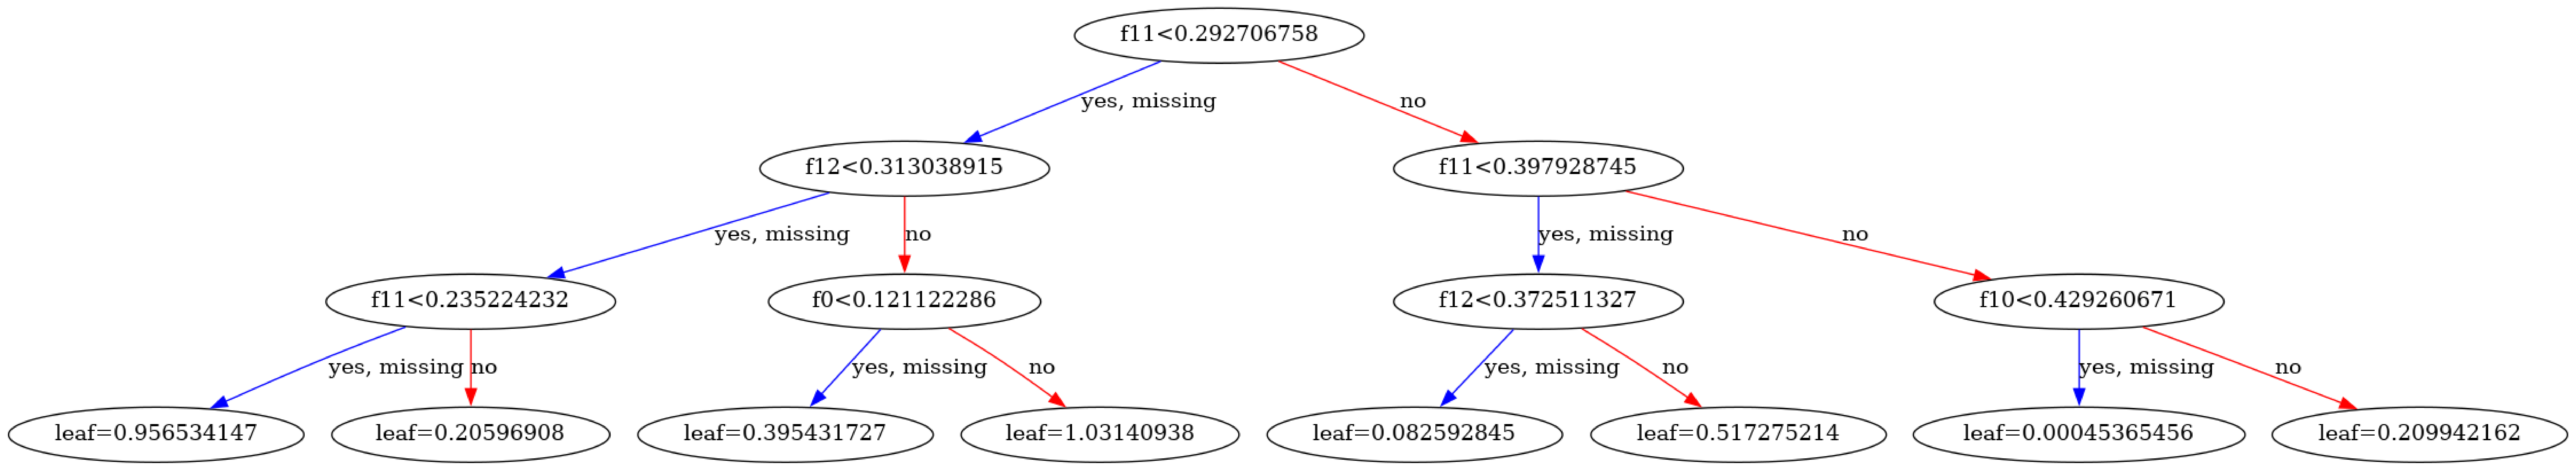

In [111]:
import matplotlib
xgb.plot_tree(xg, num_trees=2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

## Support Vector Machine

In [112]:
from sklearn import svm  #Importing module for svm

In [113]:
clf=svm.SVC(kernel='linear', random_state=1)  #Choosing linear kernel and random_state as 1 for svm

In [114]:
clf.fit(train_x,train_y)  #Training on svm

SVC(kernel='linear', random_state=1)

In [115]:
print("SVM train Accuracy : ", metrics.accuracy_score(train_y, clf.predict(train_x)))
print("SVM test Accuracy : ", metrics.accuracy_score(test_y, clf.predict(test_x)))

SVM train Accuracy :  0.619388276516534
SVM test Accuracy :  0.11563351498637602


In [116]:
clf.support_vectors_.shape #shape of support vectors

(10863, 20)

In [117]:
clf.support_ ##indices of support vectors

array([   85,   834,   909, ..., 11293, 11803, 12838], dtype=int32)

In [118]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', C=10000, gamma=0.01, random_state=1) #when c=50 accuracy-around 49
clf.fit(train_x,train_y)
print("SVM train Accuracy : ", metrics.accuracy_score(train_y, clf.predict(train_x)))
print("SVM test Accuracy : ", metrics.accuracy_score(test_y, clf.predict(test_x)))

SVM train Accuracy :  0.6137674282794364
SVM test Accuracy :  0.11529291553133515


In [119]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=10000, gamma=0.01, random_state=1)
clf.fit(train_x,train_y)
print("SVM train Accuracy : ", metrics.accuracy_score(train_y, clf.predict(train_x)))
print("SVM test Accuracy : ", metrics.accuracy_score(test_y, clf.predict(test_x)))

SVM train Accuracy :  0.6435506241331485
SVM test Accuracy :  0.11597411444141689
